In [125]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
sentence = "The mapping relies on a Monte Carlo approximation to the kernel values"
#sentence = "What made you want to look up he'll?"
sentence = "we convert each word token to lowercase, annotate it with its correct, converted wordnet tag"

### Text Normalization

In [3]:
import re
import nltk
import string
from nltk.stem import WordNetLemmatizer
import pickle
from nltk.corpus import wordnet as wn

In [4]:
CONTRACTION_MAP = pickle.load(open('contraction_map.pkl', 'rb'))

stopword_list = set(nltk.corpus.stopwords.words('english'))

wnl = WordNetLemmatizer()

In [150]:
CONTRACTION_MAP

{"'cause": 'because',
 "I'd": 'I would',
 "I'd've": 'I would have',
 "I'll": 'I will',
 "I'll've": 'I will have',
 "I'm": 'I am',
 "I've": 'I have',
 "ain't": 'is not',
 "aren't": 'are not',
 "can't": 'cannot',
 "can't've": 'cannot have',
 "could've": 'could have',
 "couldn't": 'could not',
 "couldn't've": 'could not have',
 "didn't": 'did not',
 "doesn't": 'does not',
 "don't": 'do not',
 "hadn't": 'had not',
 "hadn't've": 'had not have',
 "hasn't": 'has not',
 "haven't": 'have not',
 "he'd": 'he would',
 "he'd've": 'he would have',
 "he'll": 'he will',
 "he'll've": 'he he will have',
 "he's": 'he is',
 "how'd": 'how did',
 "how'd'y": 'how do you',
 "how'll": 'how will',
 "how's": 'how is',
 "i'd": 'i would',
 "i'd've": 'i would have',
 "i'll": 'i will',
 "i'll've": 'i will have',
 "i'm": 'i am',
 "i've": 'i have',
 "isn't": 'is not',
 "it'd": 'it would',
 "it'd've": 'it would have',
 "it'll": 'it will',
 "it'll've": 'it will have',
 "it's": 'it is',
 "let's": 'let us',
 "ma'am": 'mad

In [5]:
len(CONTRACTION_MAP), len(stopword_list)

(123, 179)

In [6]:
def tokenize_text(text):
    '''tokenize and remove extraneous whitespace'''
    return [t.strip() for t in nltk.word_tokenize(text)]


def expand_contraction(text, contraction_map):
    '''expanding contractions'''
    pattern = re.compile("({})".format("|".join(contraction_map.keys())), 
                         flags=re.IGNORECASE|re.DOTALL)
    
    def expand_match(match_obj):
        match = match_obj.group(0)
        first_char = match[0]
        text = contraction_map.get(match, contraction_map.get(match.lower()))
        return first_char + text[1:]
    
    expand_text = pattern.sub(expand_match, text)
    expand_text = re.sub("'", "", expand_text)
    return expand_text


# Annotate text tokens with POS tags
def pos_tag_text(text):
    # convert Penn treebank tag to wordnet tag
    def penn_to_wn_tags(pos_tag):
        if pos_tag.startswith('J'):
            return wn.ADJ
        elif pos_tag.startswith('V'):
            return wn.VERB
        elif pos_tag.startswith('N'):
            return wn.NOUN
        elif pos_tag.startswith('R'):
            return wn.ADV
        return None
    
    tagged_text = nltk.pos_tag(nltk.word_tokenize(text))
    tagged_lower_text = [(word.lower(), penn_to_wn_tags(pos_tag)) 
                          for word, pos_tag in tagged_text]
    return tagged_lower_text

# lemmatize text based on POS tags
def lemmatize_text(text):
    
    pos_tagged_text = pos_tag_text(text)
    lemmatized_tokens = [wnl.lemmatize(word, pos_tag) if pos_tag else word
                        for word, pos_tag in pos_tagged_text]
    return " ".join(lemmatized_tokens)

def remove_special_characters(text):
    #text = expand_contraction(text, CONTRACTION_MAP)
    pattern = re.compile("[{}]".format(re.escape(string.punctuation)))
    return pattern.sub("", text)

def remove_stopwords(text):
    return " ".join(t for t in tokenize_text(text) if t not in stopword_list)

def normalize_corpus(corpus, tokenize=False):
    normalize_corpus = []
    for text in corpus:
        text = expand_contraction(text, CONTRACTION_MAP)
        text = lemmatize_text(text)
        text = remove_special_characters(text)
        text = remove_stopwords(text)
        normalize_corpus.append(text)
        if tokenize:
            normalize_corpus.append(tokenize_text(text))
    return normalize_corpus

In [7]:
sentence = "This is a very simple sentence about ..."
lemmatize_text(remove_special_characters(sentence))

'this be a very simple sentence about'

In [8]:
normalize_corpus([sentence])

['simple sentence']

## Feature extraction

In [9]:
CORPUS = [
    'the sky is blue',
    'sky is blue and sky is beautiful',
    'the beautiful sky is so blue',
    'i love blue cheese'
]

new_doc = ['loving this blue sky today']

### Bag of Words Model

In [10]:
from sklearn.feature_extraction.text import CountVectorizer


In [11]:
CountVectorizer()

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [12]:
def bow_extractor(corpus, ngram_range=(1, 1)):
    vectorizer = CountVectorizer(min_df=1, ngram_range=ngram_range)
    features = vectorizer.fit_transform(corpus)
    return vectorizer, features


def display_features(features, feature_names):
    return pd.DataFrame(features, columns=feature_names)

In [13]:
bow_vectorizer, bow_features = bow_extractor(CORPUS)

In [14]:
display_features(bow_features.todense(), bow_vectorizer.get_feature_names())

,and,beautiful,blue,cheese,is,love,sky,so,the
0,0,0,1,0,1,0,1,0,1
1,1,1,1,0,2,0,2,0,0
2,0,1,1,0,1,0,1,1,1
3,0,0,1,1,0,1,0,0,0


In [15]:
display_features(bow_vectorizer.transform(new_doc).todense(), bow_vectorizer.get_feature_names())

,and,beautiful,blue,cheese,is,love,sky,so,the
0,0,0,1,0,0,0,1,0,0


In [16]:
bow_vectorizer_norm, bow_features_norm = bow_extractor(normalize_corpus(CORPUS))

In [17]:
display_features(bow_features_norm.todense(), bow_vectorizer_norm.get_feature_names())

,beautiful,blue,cheese,love,sky
0,0,1,0,0,1
1,1,1,0,0,2
2,1,1,0,0,1
3,0,1,1,1,0


In [18]:
display_features(bow_vectorizer_norm.transform(normalize_corpus(new_doc)).todense(), 
                 bow_vectorizer_norm.get_feature_names())

,beautiful,blue,cheese,love,sky
0,0,1,0,1,1


In [19]:
bow_vectorizer_3, bow_features_3 = bow_extractor(CORPUS, (1, 3))

In [20]:
display_features(bow_features_3.todense(), bow_vectorizer_3.get_feature_names())

,and,and sky,and sky is,beautiful,beautiful sky,beautiful sky is,blue,blue and,blue and sky,blue cheese,...,sky is beautiful,sky is blue,sky is so,so,so blue,the,the beautiful,the beautiful sky,the sky,the sky is
0,0,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,1,0,0,1,1
1,1,1,1,1,0,0,1,1,1,0,...,1,1,0,0,0,0,0,0,0,0
2,0,0,0,1,1,1,1,0,0,0,...,0,0,1,1,1,1,1,1,0,0
3,0,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0


### TF-IDF Model

In [21]:
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer

In [22]:
def tfidf_transformer(bow_matrix, norm='l2'):
    
    transformer = TfidfTransformer(norm=norm, 
                                   use_idf=True, 
                                   smooth_idf=True,)
    
    tfidf_matrix = transformer.fit_transform(bow_matrix)
    return transformer, tfidf_matrix


def tfidf_extractor(corpus, ngram_range=(1, 1)):
    
    vectorizer = TfidfVectorizer(min_df=1, ngram_range=ngram_range, 
                                 norm='l2', smooth_idf=True, use_idf=True)
    
    tfidf_matrix = vectorizer.fit_transform(corpus)
    
    return vectorizer, tfidf_matrix

In [23]:
col_names = bow_vectorizer.get_feature_names()

In [24]:
tfidf_vectorizer, tfidf_matrix = tfidf_transformer(bow_features, norm='l1')

display_features(tfidf_matrix.todense(), col_names).round(2)

,and,beautiful,blue,cheese,is,love,sky,so,the
0,0.00,0.00,0.20,0.0,0.25,0.0,0.25,0.00,0.30
1,0.21,0.16,0.11,0.0,0.26,0.0,0.26,0.00,0.00
2,0.00,0.18,0.12,0.0,0.15,0.0,0.15,0.23,0.18
3,0.00,0.00,0.21,0.4,0.00,0.4,0.00,0.00,0.00


In [25]:
tfidf_vectorizer, tfidf_matrix = tfidf_transformer(bow_features)

display_features(tfidf_matrix.todense(), col_names).round(2)

,and,beautiful,blue,cheese,is,love,sky,so,the
0,0.00,0.00,0.40,0.00,0.49,0.00,0.49,0.00,0.60
1,0.44,0.35,0.23,0.00,0.56,0.00,0.56,0.00,0.00
2,0.00,0.43,0.29,0.00,0.35,0.00,0.35,0.55,0.43
3,0.00,0.00,0.35,0.66,0.00,0.66,0.00,0.00,0.00


In [26]:
display_features(tfidf_vectorizer.transform(bow_vectorizer.transform(new_doc)).todense(), 
                 col_names).round(2)

,and,beautiful,blue,cheese,is,love,sky,so,the
0,0.0,0.0,0.63,0.0,0.0,0.0,0.77,0.0,0.0


In [27]:
# calculate tfidf manually
import scipy.sparse as sp

In [28]:
tf_matrix = np.array(bow_features.todense(), dtype=float)
tf_matrix

array([[ 0.,  0.,  1.,  0.,  1.,  0.,  1.,  0.,  1.],
       [ 1.,  1.,  1.,  0.,  2.,  0.,  2.,  0.,  0.],
       [ 0.,  1.,  1.,  0.,  1.,  0.,  1.,  1.,  1.],
       [ 0.,  0.,  1.,  1.,  0.,  1.,  0.,  0.,  0.]])

In [29]:
display_features(tf_matrix, col_names)

,and,beautiful,blue,cheese,is,love,sky,so,the
0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
1,1.0,1.0,1.0,0.0,2.0,0.0,2.0,0.0,0.0
2,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0
3,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0


In [30]:
# doc freq
df = tf_matrix.astype(bool).sum(axis=0) + 1
df

array([2, 3, 5, 2, 4, 2, 4, 2, 3])

In [31]:
# idf = 1 + log(C+1 / tf+1)

C = tf_matrix.shape[0]

idf = np.log((C+1) / df) + 1
idf

array([ 1.91629073,  1.51082562,  1.        ,  1.91629073,  1.22314355,
        1.91629073,  1.22314355,  1.91629073,  1.51082562])

In [32]:
tf_idf_matrix = (tf_matrix * idf[None, :]).round(2)

In [33]:
tf_idf_matrix

array([[ 0.  ,  0.  ,  1.  ,  0.  ,  1.22,  0.  ,  1.22,  0.  ,  1.51],
       [ 1.92,  1.51,  1.  ,  0.  ,  2.45,  0.  ,  2.45,  0.  ,  0.  ],
       [ 0.  ,  1.51,  1.  ,  0.  ,  1.22,  0.  ,  1.22,  1.92,  1.51],
       [ 0.  ,  0.  ,  1.  ,  1.92,  0.  ,  1.92,  0.  ,  0.  ,  0.  ]])

In [34]:
# l2 normalize -> each row
tf_idf_norm = tf_idf_matrix / np.linalg.norm(tf_idf_matrix, axis=1, keepdims=True)

In [35]:
display_features(tf_idf_norm.round(2), col_names)

,and,beautiful,blue,cheese,is,love,sky,so,the
0,0.00,0.00,0.40,0.00,0.49,0.00,0.49,0.00,0.60
1,0.44,0.35,0.23,0.00,0.56,0.00,0.56,0.00,0.00
2,0.00,0.43,0.29,0.00,0.35,0.00,0.35,0.55,0.43
3,0.00,0.00,0.35,0.66,0.00,0.66,0.00,0.00,0.00


In [36]:
# transform new_doc using tfidf method
a = np.array(bow_vectorizer.transform(new_doc).todense(), dtype=float) * idf
a /= np.linalg.norm(a, axis=1, keepdims=True)
a.round(2)

array([[ 0.  ,  0.  ,  0.63,  0.  ,  0.  ,  0.  ,  0.77,  0.  ,  0.  ]])

In [37]:
display_features(a, col_names).round(2)

,and,beautiful,blue,cheese,is,love,sky,so,the
0,0.0,0.0,0.63,0.0,0.0,0.0,0.77,0.0,0.0


In [38]:
tfidf_vectorizer, tfidf_matrix = tfidf_extractor(CORPUS)

In [39]:
display_features(tfidf_matrix.todense().round(2), tfidf_vectorizer.get_feature_names())

,and,beautiful,blue,cheese,is,love,sky,so,the
0,0.00,0.00,0.40,0.00,0.49,0.00,0.49,0.00,0.60
1,0.44,0.35,0.23,0.00,0.56,0.00,0.56,0.00,0.00
2,0.00,0.43,0.29,0.00,0.35,0.00,0.35,0.55,0.43
3,0.00,0.00,0.35,0.66,0.00,0.66,0.00,0.00,0.00


In [40]:
display_features(tfidf_vectorizer.transform(new_doc).todense(), 
                 tfidf_vectorizer.get_feature_names()).round(2)

,and,beautiful,blue,cheese,is,love,sky,so,the
0,0.0,0.0,0.63,0.0,0.0,0.0,0.77,0.0,0.0


### Advanced Word Vectorization Models

In [41]:
import gensim
import nltk

In [42]:
TOKENIZED_CORPUS = [nltk.word_tokenize(sent) for sent in CORPUS]

tokenized_new_doc = [nltk.word_tokenize(sent) for sent in new_doc]

In [43]:
# build word2vec model
model = gensim.models.Word2Vec(sentences=TOKENIZED_CORPUS, 
                               size=10, window=10, min_count=2, sample=1e-3)

In [44]:
model['sky']

array([-0.00902445, -0.03059663,  0.00619714,  0.00140127,  0.02062266,
        0.04905912, -0.03310942,  0.031585  , -0.01510096,  0.03631796], dtype=float32)

In [45]:
model['blue']

array([-0.04295705,  0.00361034,  0.03533934, -0.00301723, -0.03600539,
       -0.03145101, -0.04008604, -0.02292028,  0.04104633, -0.01972442], dtype=float32)

### Averaged word vectors

In [46]:
def average_word_vectors(words, model, vocabulary, num_features):
    '''calculate average word vectors for a text document'''
    
    feature_vec = np.zeros((num_features, ), dtype=float)
    nwords = 0
    
    for word in words:
        if word in vocabulary:
            nwords += 1
            feature_vec += model[word]
    if nwords:
        return feature_vec / nwords
    return feature_vec


def averaged_word_vectorizer(corpus, model, num_features):
    
    vocabulary = set(model.wv.index2word)
    feature_vecs = [average_word_vectors(tokens, model, vocabulary, num_features) 
                     for tokens in corpus]
    return np.array(feature_vecs)

In [47]:
averaged_word_vectorizer(TOKENIZED_CORPUS, model, 10).round(3)

array([[-0.013, -0.019,  0.008,  0.003, -0.016,  0.004, -0.001,  0.012,
         0.014,  0.01 ],
       [ 0.005, -0.004, -0.015, -0.002,  0.002,  0.028,  0.001,  0.017,
         0.006,  0.013],
       [-0.008, -0.007, -0.002,  0.001, -0.011,  0.005,  0.003,  0.018,
         0.013,  0.002],
       [-0.043,  0.004,  0.035, -0.003, -0.036, -0.031, -0.04 , -0.023,
         0.041, -0.02 ]])

In [48]:
averaged_word_vectorizer(tokenized_new_doc, model, 10).round(3)

array([[-0.026, -0.013,  0.021, -0.001, -0.008,  0.009, -0.037,  0.004,
         0.013,  0.008]])

### TF-IDF weighted averaged word vectors

In [49]:
tfidf_matrix.todense()

matrix([[ 0.        ,  0.        ,  0.39921021,  0.        ,  0.48829139,
          0.        ,  0.48829139,  0.        ,  0.60313701],
        [ 0.44051607,  0.34730793,  0.22987956,  0.        ,  0.5623514 ,
          0.        ,  0.5623514 ,  0.        ,  0.        ],
        [ 0.        ,  0.43202578,  0.28595344,  0.        ,  0.3497621 ,
          0.        ,  0.3497621 ,  0.54796992,  0.43202578],
        [ 0.        ,  0.        ,  0.34618161,  0.66338461,  0.        ,
          0.66338461,  0.        ,  0.        ,  0.        ]])

In [50]:
tfidf_vectorizer.vocabulary_

{'and': 0,
 'beautiful': 1,
 'blue': 2,
 'cheese': 3,
 'is': 4,
 'love': 5,
 'sky': 6,
 'so': 7,
 'the': 8}

In [51]:
def tfidf_wtd_avg_word_vectors(words, tfidf_vector, tfidf_vocab, model, num_features):
    '''compute tfidf weighted averaged word vector for a document'''
    
    word_tfidfs = [tfidf_vector[0, tfidf_vocab.get(word)] if word in tfidf_vocab else 0
                                for word in words]
    word_tfidf_map = {word:tfidf_val for word, tfidf_val in zip(words, word_tfidfs)}
    
    feature_vec = np.zeros((num_features, ), dtype=float)
    wts = 0
    vocab = set(model.wv.index2word)
    for word in words:
        if word in vocab:
            feature_vec += model[word] * word_tfidf_map[word]
            wts += word_tfidf_map[word]
    if wts:
        return feature_vec / wts
    return feature_vec


def tfidf_weighted_averaged_word_vectorizer(corpus, tfidf_vectors, tfidf_vocab, model, num_features):
    '''return tfidf weighted averaged word vector for corpus'''
    assert len(corpus) == len(tfidf_vectors)
    
    features = [tfidf_wtd_avg_word_vectors(words, vec, tfidf_vocab, model, num_features)
                for words, vec in zip(corpus, tfidf_vectors)]
    
    return np.array(features)

In [52]:
corpus_tfidf = tfidf_matrix.todense()
vocab = tfidf_vectorizer.vocabulary_

wt_tfidf_word_vec_features = tfidf_weighted_averaged_word_vectorizer(TOKENIZED_CORPUS, 
                                                                     corpus_tfidf, 
                                                                     vocab, model, 10)

In [53]:
wt_tfidf_word_vec_features

array([[-0.01346301, -0.02210545,  0.00863192,  0.00434172, -0.016948  ,
         0.00210893,  0.00182713,  0.01480093,  0.01271891,  0.0099421 ],
       [ 0.00994022, -0.00803649, -0.01882209, -0.00099282,  0.00594375,
         0.03685214,  0.00373658,  0.01927835,  0.00172328,  0.02012198],
       [-0.00687397, -0.00743495, -0.00330448,  0.00093536, -0.01029633,
         0.00416343,  0.00656087,  0.02150966,  0.01168572,  0.00054393],
       [-0.04295705,  0.00361034,  0.03533934, -0.00301723, -0.03600539,
        -0.03145101, -0.04008604, -0.02292028,  0.04104632, -0.01972442]])

In [54]:
tfidf_weighted_averaged_word_vectorizer(tokenized_new_doc, tfidf_vectorizer.transform(new_doc).todense(), 
                                        vocab, model, 10)

array([[-0.02428779, -0.01520988,  0.01930569, -0.00058623, -0.0048494 ,
         0.01284457, -0.03624759,  0.00706778,  0.01015484,  0.01110934]])

## Classification Algorithms

In [120]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier

In [74]:
def remove_empty_docs(corpus, labels):
    filtered_corpus = []
    filtered_labels = []
    for doc, label in zip(corpus, labels):
        if doc.strip():
            filtered_corpus.append(doc)
            filtered_labels.append(label)
    return filtered_corpus, filtered_labels

In [80]:
data = fetch_20newsgroups(remove=('headers', 'footers', 'quotes'))

In [81]:
print(data.data[10])

I have a line on a Ducati 900GTS 1978 model with 17k on the clock.  Runs
very well, paint is the bronze/brown/orange faded out, leaks a bit of oil
and pops out of 1st with hard accel.  The shop will fix trans and oil 
leak.  They sold the bike to the 1 and only owner.  They want $3495, and
I am thinking more like $3K.  Any opinions out there?  Please email me.
Thanks.  It would be a nice stable mate to the Beemer.  Then I'll get
a jap bike and call myself Axis Motors!

-- 
-----------------------------------------------------------------------
"Tuba" (Irwin)      "I honk therefore I am"     CompuTrac-Richardson,Tx
irwin@cmptrc.lonestar.org    DoD #0826          (R75/6)


In [71]:
data.keys()

dict_keys(['target_names', 'description', 'target', 'DESCR', 'filenames', 'data'])

In [72]:
np.unique(data['target_names'])

array(['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc',
       'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware',
       'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles',
       'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt',
       'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian',
       'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc',
       'talk.religion.misc'],
      dtype='<U24')

In [82]:
corpus, labels = data['data'], data['target']

In [83]:
len(corpus)

11314

In [84]:
corpus, labels = remove_empty_docs(corpus, labels)

In [85]:
len(corpus), len(labels)

(11014, 11014)

In [86]:
train_corpus, test_corpus, train_labels, test_labels = train_test_split(corpus, labels, stratify=labels, 
                                                                        test_size=.3, random_state=42)

In [88]:
len(train_corpus), len(test_corpus), len(train_labels), len(test_labels)

(7709, 3305, 7709, 3305)

In [90]:
%%time
norm_train_corpus = normalize_corpus(train_corpus)
norm_test_corpus = normalize_corpus(test_corpus)

CPU times: user 8min 49s, sys: 1.47 s, total: 8min 50s
Wall time: 9min 6s


In [91]:
# bag of words features
bow_vectorizer, bow_train_featuress = bow_extractor(norm_train_corpus)
bow_test_features = bow_vectorizer.transform(norm_test_corpus)

In [93]:
bow_train_featuress.shape, bow_test_features.shape

((7709, 95525), (3305, 95525))

In [92]:
# tf-idf features
tfidf_vectorizer, tfidf_train_features = tfidf_extractor(norm_train_corpus)
tfidf_test_features = tfidf_vectorizer.transform(norm_test_corpus)

In [94]:
tfidf_train_features.shape, tfidf_test_features.shape

((7709, 95525), (3305, 95525))

In [95]:
# tokenize documents
tokenized_train = [nltk.word_tokenize(txt) for txt in norm_train_corpus]
tokenized_test = [nltk.word_tokenize(txt) for txt in norm_test_corpus]

In [96]:
# build word2vec model
model = gensim.models.Word2Vec(sentences=tokenized_train, size=500, 
                               window=100, min_count=30, sample=1e-3)

In [98]:
# average word vector features

avg_wv_train_features = averaged_word_vectorizer(tokenized_train, model, num_features=500)
avg_wv_test_features = averaged_word_vectorizer(tokenized_test, model, num_features=500)

In [100]:
avg_wv_test_features.shape, avg_wv_train_features.shape

((3305, 500), (7709, 500))

In [106]:
# tfidf weighted averaged word vector features
tfidf_vocab = tfidf_vectorizer.vocabulary_

tfidf_wv_train_features = tfidf_weighted_averaged_word_vectorizer(tokenized_train, 
                                                                  tfidf_train_features.todense(), 
                                                                  tfidf_vocab, 
                                                                  model, num_features=500)

tfidf_wv_test_features = tfidf_weighted_averaged_word_vectorizer(tokenized_test, 
                                                                 tfidf_test_features.todense(), 
                                                                 tfidf_vocab, 
                                                                 model, num_features=500)

In [107]:
tfidf_wv_test_features.shape, tfidf_wv_train_features.shape

((3305, 500), (7709, 500))

In [110]:
def train_predict_evaluate_model(classifier, X_train, y_train, X_test, y_test):
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    print(classification_report(y_test, y_pred, target_names=data['target_names']))
    return y_pred

In [111]:
mnb = MultinomialNB()
svm = SGDClassifier(loss='hinge', max_iter=100)

In [112]:
mnb_bow_pred = train_predict_evaluate_model(mnb, bow_train_featuress, train_labels,
                                            bow_test_features, test_labels)

                          precision    recall  f1-score   support

             alt.atheism       0.81      0.34      0.48       140
           comp.graphics       0.65      0.65      0.65       171
 comp.os.ms-windows.misc       0.83      0.03      0.06       170
comp.sys.ibm.pc.hardware       0.58      0.72      0.64       174
   comp.sys.mac.hardware       0.85      0.63      0.72       167
          comp.windows.x       0.52      0.86      0.65       177
            misc.forsale       0.89      0.60      0.71       173
               rec.autos       0.82      0.67      0.74       169
         rec.motorcycles       0.93      0.57      0.71       175
      rec.sport.baseball       0.98      0.69      0.81       173
        rec.sport.hockey       0.85      0.85      0.85       176
               sci.crypt       0.49      0.89      0.63       175
         sci.electronics       0.83      0.49      0.62       173
                 sci.med       0.79      0.86      0.83       173
         

In [113]:
svm_bow_pred = train_predict_evaluate_model(svm, bow_train_featuress, train_labels, 
                                            bow_test_features, test_labels)

                          precision    recall  f1-score   support

             alt.atheism       0.50      0.45      0.48       140
           comp.graphics       0.62      0.54      0.58       171
 comp.os.ms-windows.misc       0.49      0.56      0.52       170
comp.sys.ibm.pc.hardware       0.58      0.47      0.52       174
   comp.sys.mac.hardware       0.61      0.60      0.61       167
          comp.windows.x       0.74      0.61      0.67       177
            misc.forsale       0.68      0.62      0.65       173
               rec.autos       0.74      0.61      0.67       169
         rec.motorcycles       0.28      0.75      0.41       175
      rec.sport.baseball       0.69      0.71      0.70       173
        rec.sport.hockey       0.48      0.78      0.59       176
               sci.crypt       0.87      0.69      0.77       175
         sci.electronics       0.63      0.55      0.59       173
                 sci.med       0.82      0.59      0.69       173
         

In [114]:
mnb_tfidf_pred = train_predict_evaluate_model(mnb, tfidf_train_features, train_labels, 
                                              tfidf_test_features, test_labels)

                          precision    recall  f1-score   support

             alt.atheism       0.86      0.31      0.46       140
           comp.graphics       0.71      0.64      0.67       171
 comp.os.ms-windows.misc       0.70      0.62      0.66       170
comp.sys.ibm.pc.hardware       0.63      0.75      0.68       174
   comp.sys.mac.hardware       0.82      0.74      0.78       167
          comp.windows.x       0.68      0.82      0.75       177
            misc.forsale       0.84      0.71      0.77       173
               rec.autos       0.85      0.75      0.80       169
         rec.motorcycles       0.87      0.71      0.78       175
      rec.sport.baseball       0.91      0.77      0.83       173
        rec.sport.hockey       0.82      0.88      0.85       176
               sci.crypt       0.59      0.90      0.71       175
         sci.electronics       0.84      0.62      0.72       173
                 sci.med       0.89      0.83      0.86       173
         

In [115]:
svm_tfidf_pred = train_predict_evaluate_model(svm, tfidf_train_features, train_labels, 
                                              tfidf_test_features, test_labels)

                          precision    recall  f1-score   support

             alt.atheism       0.62      0.68      0.65       140
           comp.graphics       0.75      0.66      0.70       171
 comp.os.ms-windows.misc       0.64      0.72      0.68       170
comp.sys.ibm.pc.hardware       0.68      0.64      0.66       174
   comp.sys.mac.hardware       0.76      0.78      0.77       167
          comp.windows.x       0.76      0.84      0.80       177
            misc.forsale       0.72      0.73      0.73       173
               rec.autos       0.79      0.81      0.80       169
         rec.motorcycles       0.79      0.71      0.75       175
      rec.sport.baseball       0.84      0.84      0.84       173
        rec.sport.hockey       0.87      0.88      0.87       176
               sci.crypt       0.85      0.83      0.84       175
         sci.electronics       0.77      0.72      0.74       173
                 sci.med       0.82      0.87      0.85       173
         

In [117]:
svm_avgwv_pred = train_predict_evaluate_model(svm, avg_wv_train_features, train_labels, 
                                              avg_wv_test_features, test_labels)

                          precision    recall  f1-score   support

             alt.atheism       0.14      0.64      0.24       140
           comp.graphics       0.38      0.59      0.46       171
 comp.os.ms-windows.misc       0.60      0.40      0.48       170
comp.sys.ibm.pc.hardware       0.64      0.09      0.16       174
   comp.sys.mac.hardware       0.39      0.59      0.47       167
          comp.windows.x       0.73      0.58      0.65       177
            misc.forsale       0.54      0.76      0.63       173
               rec.autos       0.81      0.39      0.53       169
         rec.motorcycles       0.63      0.33      0.43       175
      rec.sport.baseball       0.58      0.48      0.53       173
        rec.sport.hockey       0.78      0.53      0.63       176
               sci.crypt       0.77      0.61      0.68       175
         sci.electronics       0.37      0.26      0.30       173
                 sci.med       0.66      0.59      0.62       173
         

In [118]:
svm_tfidfwv_pred = train_predict_evaluate_model(svm, tfidf_wv_train_features, train_labels, 
                                                tfidf_wv_test_features, test_labels)

                          precision    recall  f1-score   support

             alt.atheism       0.29      0.11      0.16       140
           comp.graphics       0.42      0.40      0.41       171
 comp.os.ms-windows.misc       0.58      0.34      0.42       170
comp.sys.ibm.pc.hardware       0.44      0.34      0.39       174
   comp.sys.mac.hardware       0.30      0.56      0.39       167
          comp.windows.x       0.61      0.68      0.64       177
            misc.forsale       0.61      0.60      0.60       173
               rec.autos       0.69      0.57      0.62       169
         rec.motorcycles       0.59      0.45      0.51       175
      rec.sport.baseball       0.58      0.42      0.48       173
        rec.sport.hockey       0.60      0.79      0.68       176
               sci.crypt       0.70      0.68      0.69       175
         sci.electronics       0.61      0.47      0.53       173
                 sci.med       0.64      0.67      0.66       173
         

In [124]:
col_idx = pd.MultiIndex.from_product([['Predict'], data['target_names']])
row_idx = pd.MultiIndex.from_product([['Actual'], data['target_names']])
conmat = pd.DataFrame(confusion_matrix(test_labels, svm_tfidf_pred), columns=col_idx, index=row_idx)

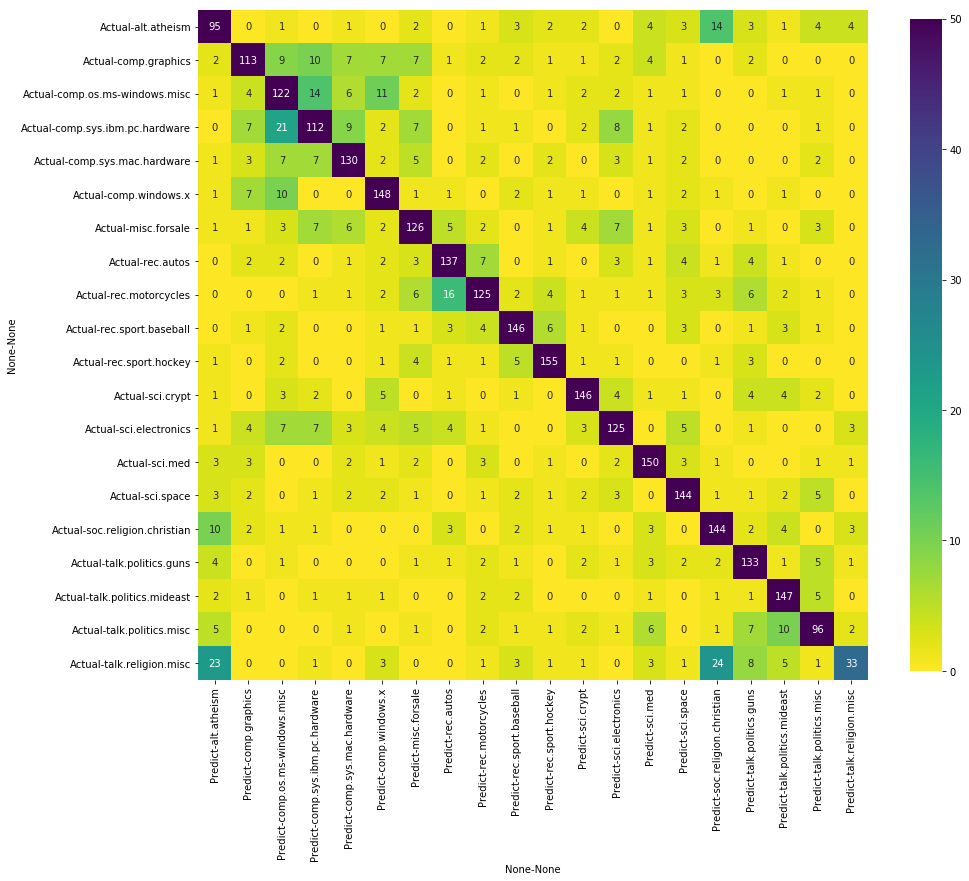

In [133]:
fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(conmat, square=True, annot=True, fmt='d', vmin=0, vmax=50, 
            cmap=plt.cm.viridis_r, ax=ax, cbar_kws={'shrink':.8})

In [135]:
data['target_names'][0], data['target_names'][15]

('alt.atheism', 'soc.religion.christian')

In [148]:
for i, val in enumerate(np.logical_and(np.array(test_labels)==0, svm_tfidf_pred==15)):
    if val:
        print(test_corpus[i])
        print('-'*50)

To all a.a readers:
     I have been asked be several of you to post a list of the SDA Church's 
27 Fundamental beliefs.  I warn you now, it's a long list.  However, I'll 
post it on Sunday.  Sabbath is coming up soon so I won't be reading on 
Saturday.  And I don't have time to do it now.
     I would GREATLY appreciate it if you would keep me in touch with what's 
going on.
     I hope all of you have a reastful and relaxing weekend.  I hope it's 
the best one so far!!
--------------------------------------------------



Do you honestly hold to that tripe Charley? For a start there are enough
current versions of the Bible to make comparisons to show that what you write
above is utter garbage. Witness JW, Mormon, Catholic, Anglican, and Greek
Orthodox Bibles. But to really convince you I'd have to take you to a good
old library. In our local library we had a 1804 King James which I compared
to a brand new, hot of God's tongue Good News Bible. Genesis was almost
unrecognisable, many o